In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from Code.Tutorial.Dataset import load_scg

In [5]:
def std_data(noise_level):
    signals_train_l, labels_train_l, duration, fs = load_scg(noise_level, 'train')
    signals_test_l, labels_test_l, _, _ = load_scg(noise_level, 'test')

    signals_l_train_ls = []
    labels_l_train_ls = []
    for cnt, signal in enumerate(signals_train_l):
        if max(signal) > 1:
            continue
        signals_l_train_ls.append(signal)
        labels_l_train_ls.append(labels_train_l[cnt])

    signals_l_test_ls = []
    labels_l_test_ls = []
    for cnt, signal in enumerate(signals_test_l):
        if max(signal) > 1:
            continue
        signals_l_test_ls.append(signal)
        labels_l_test_ls.append(labels_test_l[cnt])


    signals_l_train = np.array(signals_l_train_ls)
    signals_l_test = np.array(signals_l_test_ls)
    labels_l_train = np.array(labels_l_train_ls)
    labels_l_test = np.array(labels_l_test_ls)
    print(signals_l_train.shape, labels_l_test.shape)
    return labels_l_train, labels_l_test, signals_l_train, signals_l_test

In [6]:
def update_array(a, data_tmp):
    i = 0
    while i < len(a) - 2:
        if data_tmp[a[i]] < data_tmp[a[i + 1]] < data_tmp[a[i + 2]]:
            a = np.delete(a, i)
        elif data_tmp[a[i]] > data_tmp[a[i + 1]] > data_tmp[a[i + 2]]:
            a = np.delete(a, i + 2)
        else:
            i += 1
    return a

In [7]:
def delete_unique(a):
    mean = np.mean(a)
    std = np.std(a)
    threshold = 1
    filtered_a = a[np.abs(a - mean) <= threshold * std]

    return filtered_a

def get_mag_0(peaks2, data_tmp):
    mag = data_tmp[peaks2[::2]]
    mean_mag = np.mean(mag)
    std_mag = np.std(mag)
    filtered_mag = mag[np.abs(mag-mean_mag) <= std_mag]
    return np.mean(filtered_mag)

def get_mag_1(peaks2, data_tmp):
    mag = data_tmp[peaks2[1::2]]
    mean_mag = np.mean(mag)
    std_mag = np.std(mag)
    filtered_mag = mag[np.abs(mag-mean_mag) <= std_mag]
    return np.mean(filtered_mag)

def get_features(data_tmp, peaks2):
    maxm = np.max(data_tmp)
    data_tmp_raw = data_tmp

    data_tmp = data_tmp_raw / maxm

    diff_12 = peaks2[1::2] - peaks2[0::2]
    diff_21 = peaks2[2::2] - peaks2[1:-1:2]

    diff_12 = delete_unique(diff_12)
    diff_21 = delete_unique(diff_21)

    m_12 = np.mean(diff_12)
    m_21 = np.mean(diff_21)

    mag_1 = get_mag_1(peaks2, data_tmp)
    mag_0 = get_mag_0(peaks2, data_tmp)

    features = np.array([ m_12/m_21, mag_0/mag_1])

    return features

In [129]:
from tslearn.clustering import KShape
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

def KShapes_iter(signal_pieces):
    # for i in [5, 4, 3]:
    for i in [3]:
        ks, y_pred = KShapes(signal_pieces, i)
        all_N = len(y_pred)
        # print(y_pred)
        clusters_percent = np.array([ (y_pred == k).sum() / all_N for k in range(i)])
        # print(clusters_percent)
        position = np.where(clusters_percent >= 0.5)[0]
        # print(position)
        if position.any():
            return ks.cluster_centers_[position].ravel()
        else:
            continue

    ks, y_pred = KShapes(signal_pieces, 2)
    all_N = len(y_pred)
    cluster_1 = np.sum(y_pred)
    if cluster_1 >= all_N - cluster_1:
        return ks.cluster_centers_[1].ravel()
    else:
        return ks.cluster_centers_[0].ravel()


def KShapes(signal_pieces, num_clusters=2, show=False, seed=42):
    np.random.seed(seed)

    X_train = signal_pieces
    X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)
    sz = X_train.shape[1]

    ks = KShape(n_clusters=num_clusters, verbose=False, random_state=seed)
    y_pred = ks.fit_predict(X_train)

    if show:
        plt.figure()
        for yi in range(num_clusters):
            plt.subplot(num_clusters, 1, 1 + yi)
            for xx in X_train[y_pred == yi]:
                plt.plot(xx.ravel(), "k-", alpha=.2)
            plt.plot(ks.cluster_centers_[yi].ravel(), "r-")
            plt.xlim(0, sz)
            plt.title("Cluster %d" % (yi + 1))
        plt.tight_layout()

    return ks, y_pred

In [130]:
def segmentation(signal, rpeak, model, h, d):
    begin, end = 0, 0
    margin = rpeak[0]
    pieces = []

    for num in range(1, len(rpeak)):
        begin = end
        end = rpeak[num] - margin
        pieces.append(signal[begin: end])

    Nmax = 0
    for piece in pieces:
        Nmax = max(Nmax, piece.shape[0])

    pieces_padded = []
    for piece in pieces:
        N = Nmax - piece.shape[0]
        pieces_padded.append(np.pad(piece, (0, N), 'constant'))
    pieces_padded = np.array(pieces_padded)

    if model==1:
        template = np.median(pieces_padded, 0)
    if model==2:
        template = np.mean(pieces_padded, 0)
    if model==3:
        template = KShapes_iter(pieces_padded)

    template_peaks_, _ = find_peaks(template, height=np.max(template) * h, distance=len(template) * d)
    template_peaks = []

    if len(template_peaks_) == 2:
        template_peaks = template_peaks_
    elif len(template_peaks_) > 2:
        mmax = np.argmax(template[template_peaks_])
        template_peaks.append(template_peaks_[mmax])
        template_peaks_ = np.delete(template_peaks_, mmax)
        mmax2 = np.argmax(template[template_peaks_])
        template_peaks.append(template_peaks_[mmax2])
    elif len(template_peaks_) < 2:
        # plt.figure()
        # plt.plot(template)
        # plt.scatter(template_peaks_, template[template_peaks_])
        # plt.show()
        return None

    dis12 = template_peaks[1] - template_peaks[0]
    dis21 = Nmax - dis12
    A0 = template[template_peaks[0]]
    A1 = template[template_peaks[1]]
    #
    # if dis12 / dis21 < 0.5:
    #     plt.figure()
    #     plt.plot(template)
    #     plt.scatter(template_peaks, template[template_peaks])
    #     plt.title(f'dis12/dis21:{dis12/dis21}, A0/A1:{A0/A1}')
    #     plt.show()

    return [dis12/dis21, A0/A1]

In [131]:
# 1. find large peaks
# 2. don't get template and get features
# 3. seg and get template and get features (1, 2, 3)
# 4. LR

In [ ]:
from tqdm import tqdm
if __name__=='__main__':
    labels_l_0_train, labels_l_0_test, signals_l_0_train, signals_l_0_test = std_data(0)
    labels_l_1_train, labels_l_1_test, signals_l_1_train, signals_l_1_test = std_data(0.1)

    def extract(signals, labels, h, d, alpha):
        show = False
        features_NoTemplate = []
        features_MedianTemplate = []
        features_MeanTemplate = []
        features_KshapesTemplate = []

        for cnt, signal in tqdm(enumerate(signals)):

            hr = labels[cnt, 2]
            allpeaks, _ = find_peaks(signal, height=np.max(signal) * 0.1, distance=2000 // (hr * alpha))
            allpeaks = update_array(allpeaks, signal / np.max(signal))
            if len(allpeaks) % 2 != 0:
                allpeaks = np.delete(allpeaks, len(allpeaks) - 1)
            features_NoTemplate.append(get_features(signal, allpeaks))

            largepeaks, _ = find_peaks(signal, height=np.max(signal) * 0.3, distance=5000 // (hr * alpha))
            # _, flag = segmentation(signal, largepeaks, 1,  h, d)
            # print( flag)
            # features_MedianTemplate.append(feature)


            features_MedianTemplate.append(segmentation(signal, largepeaks, 1,  h, d))
            features_MeanTemplate.append(segmentation(signal, largepeaks, 2,  h, d))
            features_KshapesTemplate.append(segmentation(signal, largepeaks, 3,  h, d))

            if show:
                print(hr)
                plt.figure()
                plt.plot(signal)
                plt.scatter(largepeaks, signal[largepeaks])
                plt.show()

        return  np.array(features_NoTemplate), np.array(features_MedianTemplate), np.array(features_MeanTemplate)

    features_NoTemplate_train,features_MedianTemplate_train,features_MeanTemplate_train=extract(signals_l_0_train,labels_l_0_train,0.1,0.15, 1)
    features_NoTemplate_test,features_MedianTemplate_test,features_MeanTemplate_test=extract(signals_l_0_test,labels_l_0_test,0.12,0.12, 1.2)


(4718, 1000) (2822, 6)
(4718, 1000) (2822, 6)


179it [00:14, 11.77it/s]

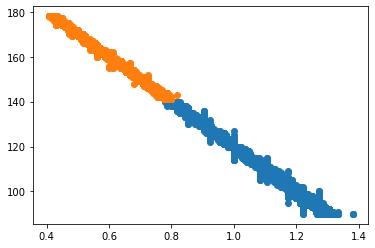

0.7919189665840222


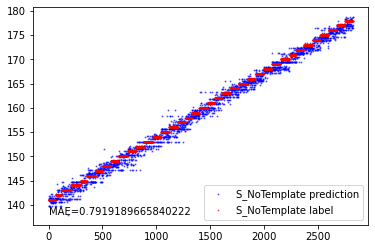

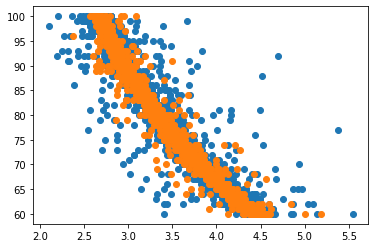

1.7920053653338592


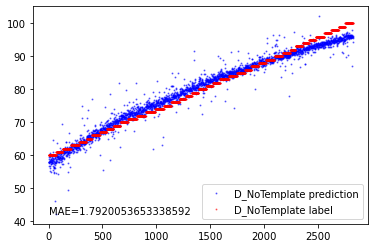

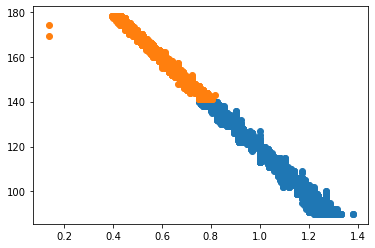

1.4507940856026877


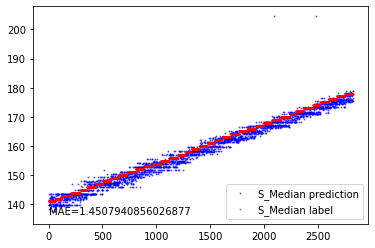

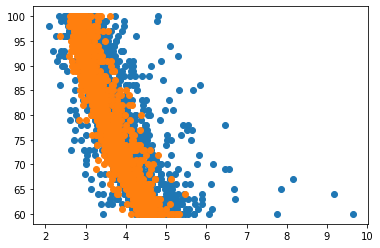

4.074345682278508


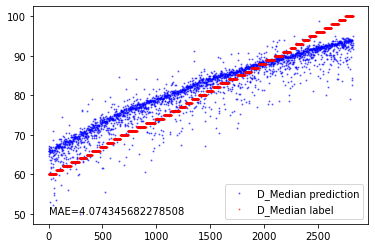

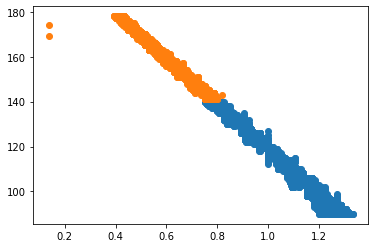

1.350096033477893


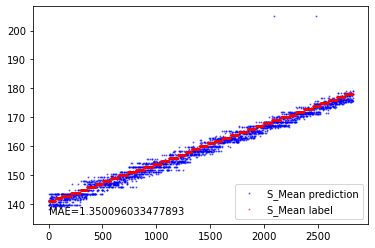

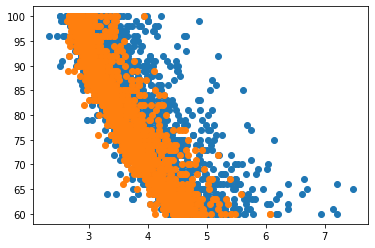

4.53378533599521


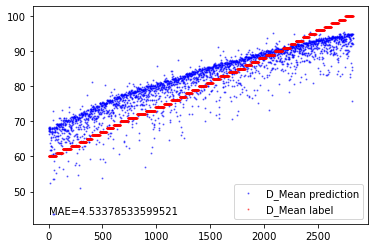

In [128]:
from sklearn.linear_model import LinearRegression as LR
# from Code.Tutorial.utils import plot_2vectors

def plot_plot(features_train, features_test, labels_train, labels_test, title):
    plt.figure()
    plt.scatter(np.array(features_train), labels_train)
    plt.scatter(np.array(features_test), labels_test)
    plt.show()

    reg = LR().fit(np.array(features_train).reshape(-1, 1), labels_train)
    yhat = reg.predict(np.array(features_test).reshape(-1, 1))
    print(np.mean(np.abs(yhat - labels_test)))

    plot_2vectors(labels_test, yhat, False, title)

# plot_plot(features_NoTemplate_train[:, 0],features_NoTemplate_test[:, 0],labels_l_0_train[:, 4],labels_l_0_test[:, 4],'S_NoTemplate')
# plot_plot(features_NoTemplate_train[:, 1],features_NoTemplate_test[:, 1],labels_l_0_train[:, 5],labels_l_0_test[:, 5],'D_NoTemplate')
plot_plot(features_MedianTemplate_train[:, 0],features_MedianTemplate_test[:, 0],labels_l_0_train[:, 4],labels_l_0_test[:, 4],'S_Median')
plot_plot(features_MedianTemplate_train[:, 1],features_MedianTemplate_test[:, 1],labels_l_0_train[:, 5],labels_l_0_test[:, 5],'D_Median')
plot_plot(features_MeanTemplate_train[:, 0],features_MeanTemplate_test[:, 0],labels_l_0_train[:, 4],labels_l_0_test[:, 4],'S_Mean')
plot_plot(features_MeanTemplate_train[:, 1],features_MeanTemplate_test[:, 1],labels_l_0_train[:, 5],labels_l_0_test[:, 5],'D_Mean')





